In [1]:

import pandas as pd
import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

from helper.model_plots import *

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
from matplotlib.patches import Circle


In [2]:

days = pd.read_parquet('data/daily.parquet',engine='fastparquet')
labeled_users = pd.read_parquet('data/labeled_users.parquet',engine='fastparquet')
bets = pd.read_parquet('data/bets.parquet',engine='fastparquet')


In [3]:
labeled_users.groupby('cluster_label').size()


cluster_label
0    25746
1     1957
2      413
3     3442
4      456
5       88
dtype: int64

In [4]:
target_cluster_users = labeled_users[labeled_users['cluster_label'] == 0]['user_id'].to_list()
target_cluster_users[:5]


[44, 46, 5977, 7612, 9388]

In [54]:
target_cluster_users_days = days[days['user_id'].isin(target_cluster_users)]
target_cluster_users_days.head()


,user_id,day_of_year,odds_log_mean,odds_log_std,bet_prop_log_mean,bet_prop_log_std,n_sessions,n_active_hours,bet_top1hour%,bet_top2hours%,bet_top4hours%,slope_bet_day,slope_odd_day,n_bet_proportion
0,44,253,0.045360,0.027368,0.000000,0.000000,1.0,2,0.500000,1.000000,1.000000,0.000000,0.001335,1.000000
1,44,254,0.537515,0.259239,1.242422,0.736760,1.0,2,0.825483,1.000000,1.000000,-0.029744,-0.013300,1.666667
2,44,255,0.029559,0.000000,-0.069071,0.000000,1.0,1,1.000000,1.000000,1.000000,-0.000210,0.000090,0.312500
3,44,257,0.036531,0.027343,0.324303,0.698184,3.0,3,0.559135,0.782729,0.782729,0.001503,0.000293,1.342282
4,44,259,0.095418,0.104053,-0.068377,0.002970,1.0,1,1.000000,1.000000,1.000000,-0.009365,0.013068,4.866970


In [55]:
target_cluster_users_days.columns


Index(['user_id', 'day_of_year', 'odds_log_mean', 'odds_log_std',
       'bet_prop_log_mean', 'bet_prop_log_std', 'n_sessions', 'n_active_hours',
       'bet_top1hour%', 'bet_top2hours%', 'bet_top4hours%', 'slope_bet_day',
       'slope_odd_day', 'n_bet_proportion'],
      dtype='object')

In [56]:
target_days = target_cluster_users_days.drop(columns=['user_id','day_of_year'])
target_days.head()


,odds_log_mean,odds_log_std,bet_prop_log_mean,bet_prop_log_std,n_sessions,n_active_hours,bet_top1hour%,bet_top2hours%,bet_top4hours%,slope_bet_day,slope_odd_day,n_bet_proportion
0,0.045360,0.027368,0.000000,0.000000,1.0,2,0.500000,1.000000,1.000000,0.000000,0.001335,1.000000
1,0.537515,0.259239,1.242422,0.736760,1.0,2,0.825483,1.000000,1.000000,-0.029744,-0.013300,1.666667
2,0.029559,0.000000,-0.069071,0.000000,1.0,1,1.000000,1.000000,1.000000,-0.000210,0.000090,0.312500
3,0.036531,0.027343,0.324303,0.698184,3.0,3,0.559135,0.782729,0.782729,0.001503,0.000293,1.342282
4,0.095418,0.104053,-0.068377,0.002970,1.0,1,1.000000,1.000000,1.000000,-0.009365,0.013068,4.866970


In [22]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(target_days)
X_scaled[0]

# original_X = scaler.inverse_transform(X_scaled)
# original_X[0]


array([-1.3602558 , -0.96073425,  0.37522426, -0.72563059, -0.41711495,
        0.37676417, -2.63472111,  0.19281784,  0.19281784,  0.00539622,
        0.02893782, -0.12624421])

In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cuda')

In [24]:
class Autoencoder(nn.Module):
    def __init__(self, input_dim, intermediate_dim, encoding_dim):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, intermediate_dim),
            nn.ReLU(),
            nn.Linear(intermediate_dim, encoding_dim),
        )
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, intermediate_dim),
            nn.ReLU(),
            nn.Linear(intermediate_dim, input_dim),
        )

    def forward(self, x):
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat


In [25]:
input_dim = X_scaled.shape[1]
encoding_dim = 4
intermediate_dim = 8


model = Autoencoder(input_dim, intermediate_dim, encoding_dim).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


In [26]:
tensor_x = torch.tensor(X_scaled, dtype=torch.float32)
dataset = TensorDataset(tensor_x) 
loader = DataLoader(dataset, batch_size=64, shuffle=True)


In [27]:
n_epochs = 50

for epoch in range(n_epochs):
    model.train()
    epoch_loss = 0.0

    for (batch,) in loader:
        batch = batch.to(device)

        optimizer.zero_grad()
        recon = model(batch)
        loss = criterion(recon, batch)

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item() * batch.size(0)

    epoch_loss /= len(dataset)
    print(f"Epoch {epoch+1}/{n_epochs} - Loss: {epoch_loss:.6f}")


Epoch 1/50 - Loss: 0.620294
Epoch 2/50 - Loss: 0.367744
Epoch 3/50 - Loss: 0.298553
Epoch 4/50 - Loss: 0.259755
Epoch 5/50 - Loss: 0.244168
Epoch 6/50 - Loss: 0.233986
Epoch 7/50 - Loss: 0.226945
Epoch 8/50 - Loss: 0.222695
Epoch 9/50 - Loss: 0.219805
Epoch 10/50 - Loss: 0.217369
Epoch 11/50 - Loss: 0.214841
Epoch 12/50 - Loss: 0.212100
Epoch 13/50 - Loss: 0.208101
Epoch 14/50 - Loss: 0.203287
Epoch 15/50 - Loss: 0.197447
Epoch 16/50 - Loss: 0.189930
Epoch 17/50 - Loss: 0.182464
Epoch 18/50 - Loss: 0.176773
Epoch 19/50 - Loss: 0.173205
Epoch 20/50 - Loss: 0.171288
Epoch 21/50 - Loss: 0.170006
Epoch 22/50 - Loss: 0.168789
Epoch 23/50 - Loss: 0.168059
Epoch 24/50 - Loss: 0.167235
Epoch 25/50 - Loss: 0.166403
Epoch 26/50 - Loss: 0.166004
Epoch 27/50 - Loss: 0.165303
Epoch 28/50 - Loss: 0.165055
Epoch 29/50 - Loss: 0.164702
Epoch 30/50 - Loss: 0.164292
Epoch 31/50 - Loss: 0.163902
Epoch 32/50 - Loss: 0.164013
Epoch 33/50 - Loss: 0.163371
Epoch 34/50 - Loss: 0.162972
Epoch 35/50 - Loss: 0.1

In [50]:
X_tensor = torch.tensor(X_scaled, dtype=torch.float32).to(device)

with torch.no_grad():
    X_recon = model(X_tensor).cpu().numpy()
    
recon_error = ((X_scaled - X_recon) ** 2).mean(axis=1)


In [ ]:
recon_error.mean(), recon_error.sum()


(0.15951792211000415, 11376.180133197056)

In [30]:
np.percentile(recon_error, [50, 80, 90, 95, 99])


array([0.02098098, 0.17606213, 0.36864081, 0.56510886, 1.72634622])

In [ ]:
a = [0.02098098, 0.17606213, 0.36864081, 0.56510886, 1.72634622]


In [32]:
import numpy as np
a_sqrt = np.sqrt(a)
a_sqrt


array([0.14484813, 0.41959758, 0.60715798, 0.75173723, 1.31390495])

In [34]:
recon_target = target_cluster_users_days.copy()
recon_target["recon_error"] = recon_error
recon_target.head()


,user_id,day_of_year,odds_log_mean,odds_log_std,bet_prop_log_mean,bet_prop_log_std,n_sessions,n_active_hours,bet_top1hour%,bet_top2hours%,bet_top4hours%,slope_bet_day,slope_odd_day,n_bet_proportion,recon_error
0,44,253,0.045360,0.027368,0.000000,0.000000,1.0,2,0.500000,1.000000,1.000000,0.000000,0.001335,1.000000,0.558494
1,44,254,0.537515,0.259239,1.242422,0.736760,1.0,2,0.825483,1.000000,1.000000,-0.029744,-0.013300,1.666667,0.068355
2,44,255,0.029559,0.000000,-0.069071,0.000000,1.0,1,1.000000,1.000000,1.000000,-0.000210,0.000090,0.312500,0.024950
3,44,257,0.036531,0.027343,0.324303,0.698184,3.0,3,0.559135,0.782729,0.782729,0.001503,0.000293,1.342282,0.395059
4,44,259,0.095418,0.104053,-0.068377,0.002970,1.0,1,1.000000,1.000000,1.000000,-0.009365,0.013068,4.866970,0.030008


In [68]:
user_errors = recon_target.groupby('user_id')['recon_error'].agg(['mean','count'])
user_errors[(user_errors['mean']>0) & (user_errors['count']>1)].sort_values('mean',ascending=False)


C:\Users\mathe\AppData\Local\Temp\ipykernel_31184\3575512360.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  user_errors = recon_target.groupby('user_id')['recon_error'].agg(['mean','count'])


,mean,count
user_id,,
1249661,12.390774,7
1455047,10.282375,2
1343144,8.470209,22
794521,7.341395,3
1357121,6.403667,20
...,...,...
1463932,0.002232,2
1481634,0.002125,2
1488294,0.002058,2


In [60]:
# recon_target.sort_values(by='recon_error', ascending=False)


In [70]:
user_id = 1249661


In [71]:
recon_target[recon_target['user_id'] == user_id]


,user_id,day_of_year,odds_log_mean,odds_log_std,bet_prop_log_mean,bet_prop_log_std,n_sessions,n_active_hours,bet_top1hour%,bet_top2hours%,bet_top4hours%,slope_bet_day,slope_odd_day,n_bet_proportion,recon_error
58727,1249661,258,0.559713,0.228304,0.141638,0.293819,1.0,2,0.553503,1.000000,1.000000,-0.004311,-0.018240,1.000000,0.348294
58728,1249661,262,0.508672,0.220463,0.520693,0.667373,1.0,2,0.598737,1.000000,1.000000,0.048700,0.046977,1.214286,0.267361
58729,1249661,263,1.336859,1.374884,10.395938,9.629434,1.0,1,1.000000,1.000000,1.000000,-0.257638,-0.033131,0.209790,0.268750
58730,1249661,264,0.483160,0.251357,-14.406376,2.364061,1.0,6,0.999231,0.999618,0.999618,-77.588173,2.660894,54.897495,85.555654
58731,1249661,265,0.254642,0.000000,9.573875,0.000000,1.0,1,1.000000,1.000000,1.000000,-0.029138,-0.000775,0.011883,0.237346
58732,1249661,266,0.520214,0.239220,4.467555,0.593297,1.0,1,1.000000,1.000000,1.000000,-0.116545,-0.013571,0.052744,0.047322
58733,1249661,270,0.506818,0.000000,1.786746,0.000000,1.0,1,1.000000,1.000000,1.000000,-0.010099,-0.002865,0.014566,0.010693


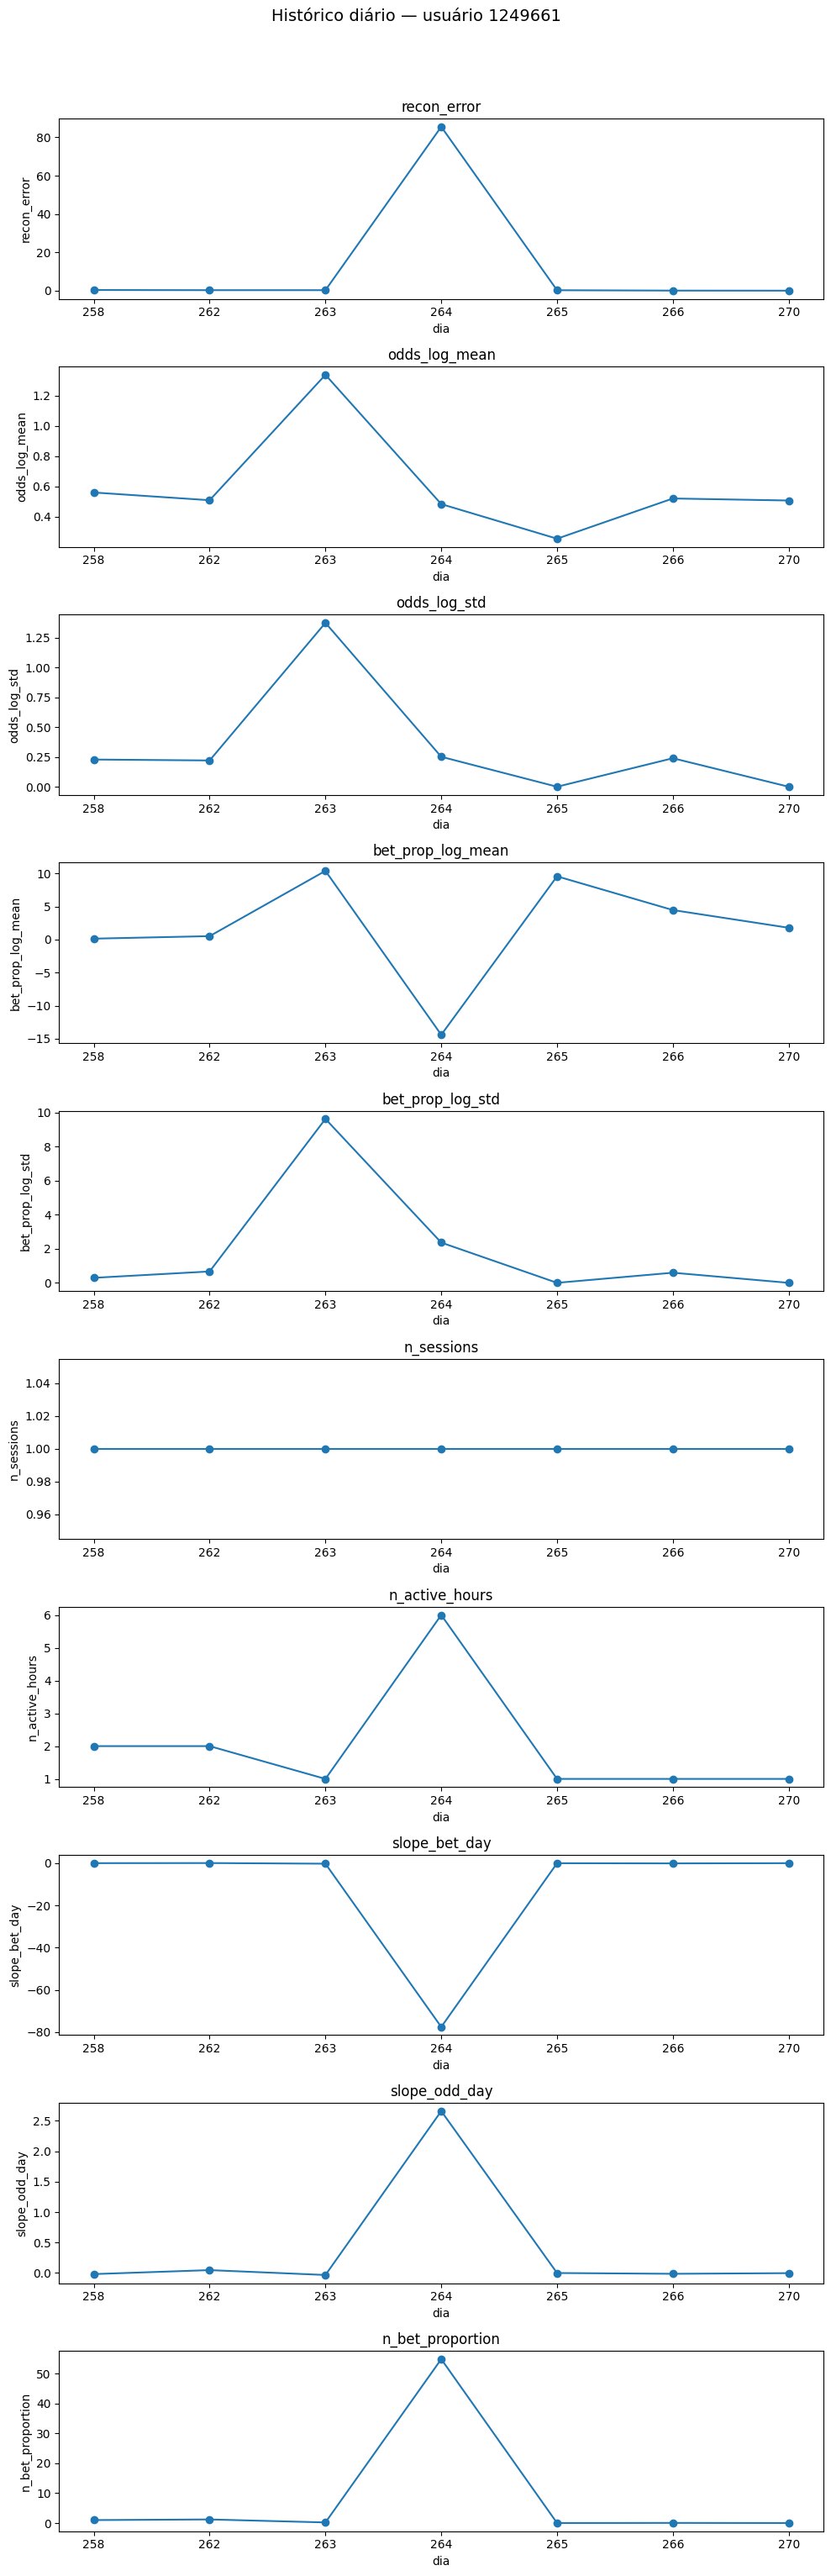

In [73]:
daily_feats = [
    'recon_error',
    'odds_log_mean', 
    'odds_log_std', 
    'bet_prop_log_mean',
    'bet_prop_log_std', 
    'n_sessions', 'n_active_hours', 
    'slope_bet_day', 'slope_odd_day', 'n_bet_proportion',
]

plot_user_daily(recon_target, user_id=user_id, features=daily_feats)


In [75]:
day = 264


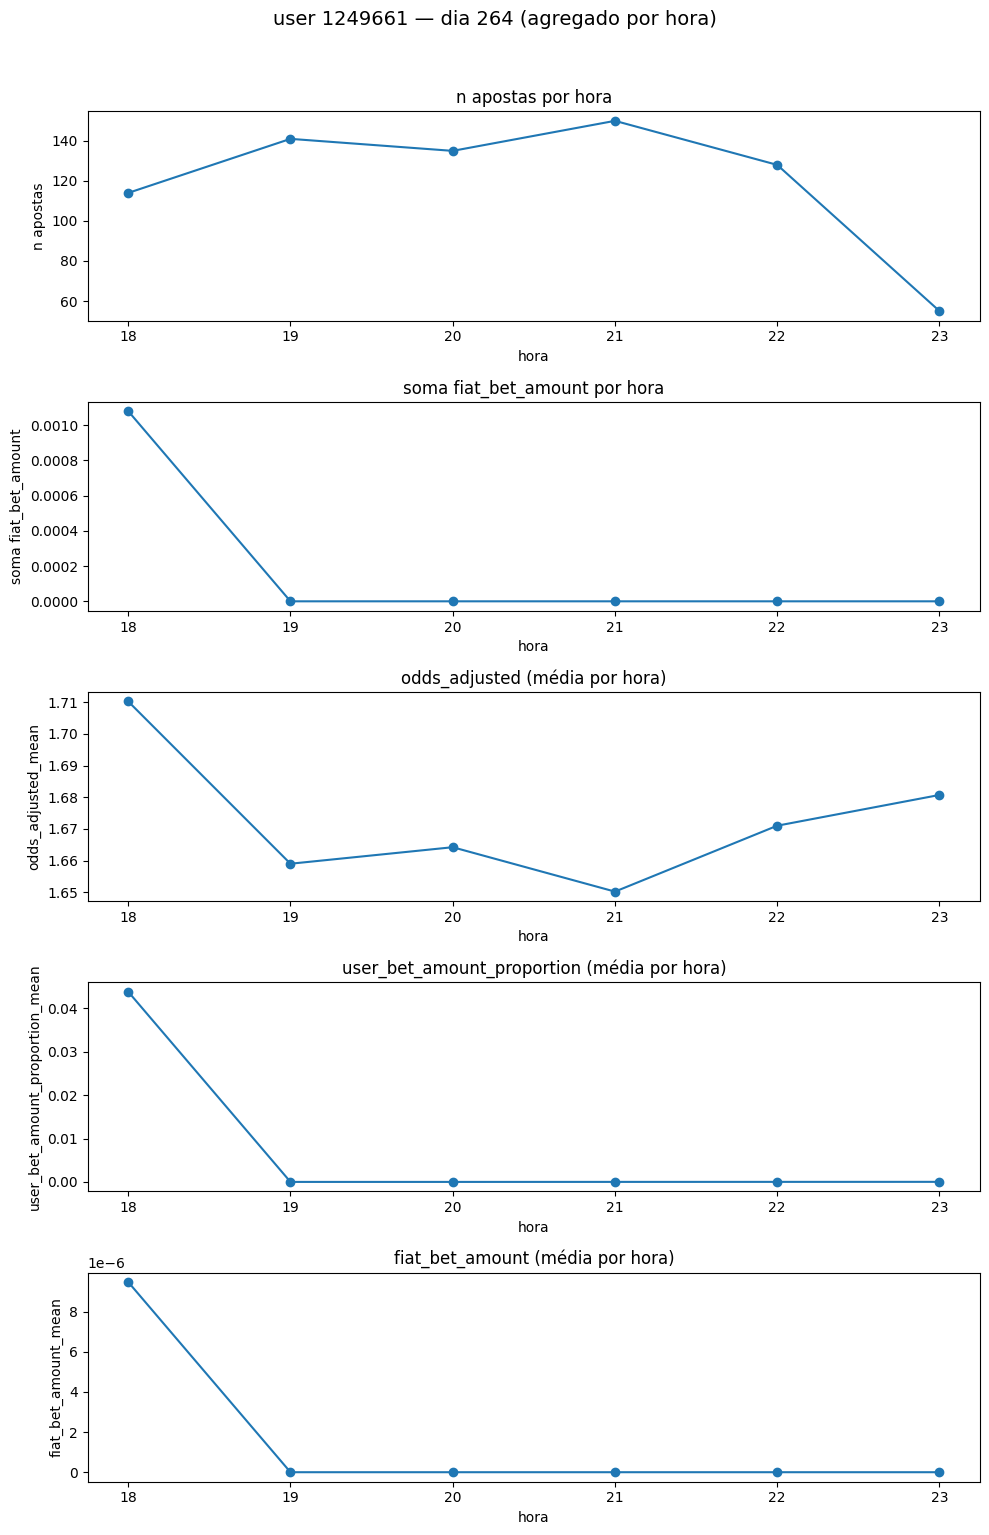

In [78]:

plot_user_day_hourly(
    df=bets,          
    user_id=user_id,
    day_of_year=day  
)



In [ ]:
plot_user_daily(recon_target, user_id=user_id, features=daily_feats)

plot_user_day_hourly(df=bets, user_id=user_id, day_of_year=day)



In [168]:
hour = 13


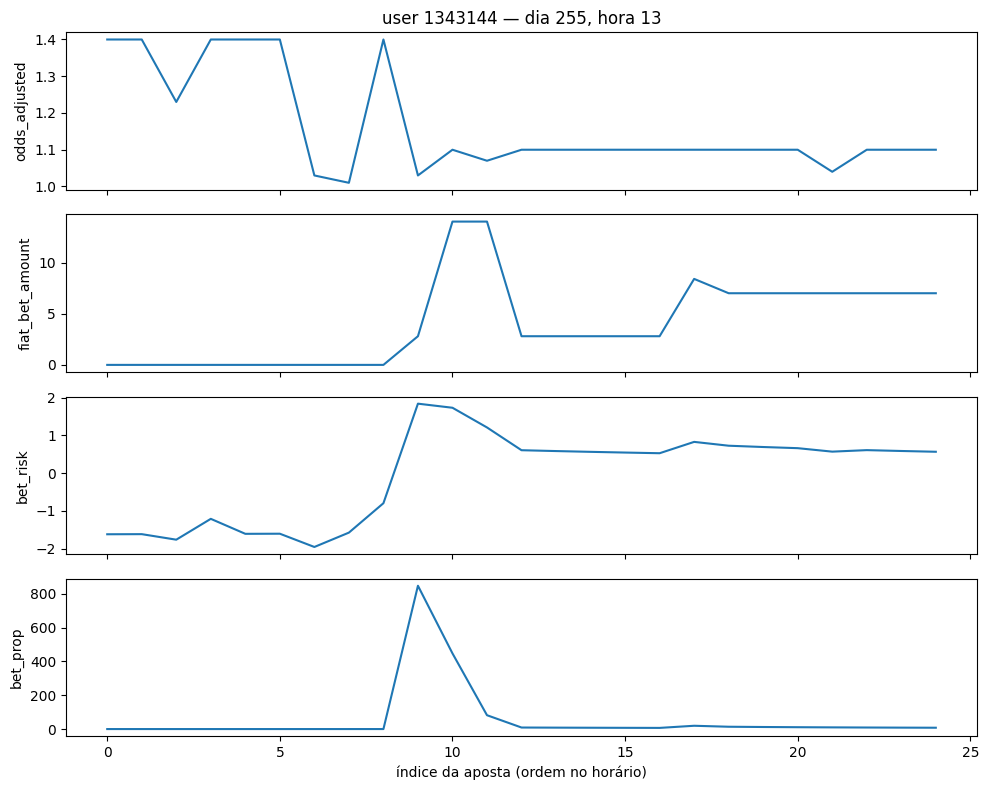

In [169]:
plot_user_hour_bets(
    df=bets,          
    user_id=user_id,
    day_of_year=day,   
    hour=hour  
)


In [23]:
all_days = days.drop(columns=['user_id','day_of_year'])
all_days


,odds_log_mean,odds_log_std,bet_prop_log_mean,bet_prop_log_std,n_sessions,n_active_hours,bet_top1hour%,bet_top2hours%,bet_top4hours%,slope_bet_day,slope_odd_day,n_bet_proportion
0,0.045360,0.027368,0.000000,0.000000,1.0,2,0.500000,1.000000,1.000000,0.000000,0.001335,1.000000
1,0.537515,0.259239,1.242422,0.736760,1.0,2,0.825483,1.000000,1.000000,-0.029744,-0.013300,1.666667
2,0.029559,0.000000,-0.069071,0.000000,1.0,1,1.000000,1.000000,1.000000,-0.000210,0.000090,0.312500
3,0.036531,0.027343,0.324303,0.698184,3.0,3,0.559135,0.782729,0.782729,0.001503,0.000293,1.342282
4,0.095418,0.104053,-0.068377,0.002970,1.0,1,1.000000,1.000000,1.000000,-0.009365,0.013068,4.866970
...,...,...,...,...,...,...,...,...,...,...,...,...
130639,0.469348,0.309348,1.480713,2.308513,1.0,1,1.000000,1.000000,1.000000,-0.042490,-0.013468,1.000000
130640,0.192760,0.105671,2.745244,2.152429,1.0,1,1.000000,1.000000,1.000000,-0.064454,-0.004526,1.000000
130641,0.386987,0.334752,-8.095021,10.176622,1.0,1,1.000000,1.000000,1.000000,0.095029,-0.004543,1.000000
130642,0.165514,0.000000,0.000000,0.000000,1.0,1,1.000000,1.000000,1.000000,0.000000,-0.000648,1.000000


In [24]:
all_scaled = scaler.transform(all_days)
all_scaled[0]


array([-1.3602558 , -0.96073425,  0.37522426, -0.72563059, -0.41711495,
        0.37676417, -2.63472111,  0.19281784,  0.19281784,  0.00539622,
        0.02893782, -0.12624421])

In [25]:
all_tensor = torch.tensor(all_scaled, dtype=torch.float32).to(device)
all_tensor[0]


tensor([-1.3603, -0.9607,  0.3752, -0.7256, -0.4171,  0.3768, -2.6347,  0.1928,
         0.1928,  0.0054,  0.0289, -0.1262], device='cuda:0')

In [26]:
with torch.no_grad():
    all_recon = model(all_tensor).cpu().numpy()


In [27]:
all_recon_error = ((all_scaled - all_recon) ** 2).mean(axis=1)


In [28]:

recon_df = days.copy()
recon_df["recon_error"] = all_recon_error


In [29]:
recon_df = recon_df.merge(labeled_users[['user_id','cluster_label']], how='left', on='user_id')


In [30]:
recon_df.groupby('cluster_label')['recon_error'].describe()


,count,mean,std,min,25%,50%,75%,max
cluster_label,,,,,,,,
0,71316.0,0.169327,0.963680,0.000162,0.006032,0.022975,0.141300,131.089194
1,20379.0,2.260761,6.113141,0.000497,0.157052,0.500430,1.773725,245.855279
2,1951.0,1.175569,4.390520,0.000499,0.008709,0.139877,0.586905,74.832804
3,30635.0,0.648663,2.280287,0.000308,0.041064,0.204299,0.517763,172.984138
4,5989.0,8.826678,13.495723,0.000643,0.887831,5.515178,13.694826,249.324219
5,374.0,5.928469,30.817160,0.000670,0.007851,0.255062,2.886821,468.137421


In [32]:
recon_df[recon_df['cluster_label'] == 1].sort_values(by='recon_error', ascending=False).head()


,user_id,day_of_year,odds_log_mean,odds_log_std,bet_prop_log_mean,bet_prop_log_std,n_sessions,n_active_hours,bet_top1hour%,bet_top2hours%,bet_top4hours%,slope_bet_day,slope_odd_day,n_bet_proportion,recon_error,cluster_label
75583,1338836,260,1.540842,0.996576,-0.655833,1.176517,1.0,24,0.084803,0.162501,0.162501,-11.449120,16.611532,2.106065,245.855279,1
55123,1225103,253,1.336099,0.883252,-0.366022,1.029961,3.0,9,0.191581,0.350316,0.350316,-4.014474,15.320982,1.000000,227.328294,1
4270,180754,261,1.220017,0.829870,-0.075421,0.423897,4.0,8,0.224221,0.430146,0.430146,0.501276,-12.674580,1.487723,156.532980,1
73596,1329183,261,1.843722,0.727841,-1.888593,2.004851,2.0,23,0.140317,0.276078,0.276078,-7.538863,12.590584,2.642288,147.892221,1
2331,115814,272,0.223014,0.234688,-15.178456,6.243322,3.0,13,0.849840,0.914918,0.914918,-87.680397,0.401351,11.000265,139.664025,1


In [180]:
recon_df.sort_values(by='recon_error', ascending=True).head()


,user_id,day_of_year,odds_log_mean,odds_log_std,bet_prop_log_mean,bet_prop_log_std,n_sessions,n_active_hours,bet_top1hour%,bet_top2hours%,...,bet_mean_abs_dev_uniform%,odd_top1hour%,odd_top2hours%,odd_top4hours%,odd_mean_abs_dev_uniform%,slope_bet_day,slope_odd_day,n_bet_proportion,recon_error,cluster_label
107203,1441962,264,0.058069,0.02304,1.198114,0.030024,1.0,1,1.0,1.0,...,0.079861,1.0,1.0,1.0,0.079861,-0.035422,-0.001717,0.584795,0.000317,0
114233,1455722,266,0.000000,0.00000,1.106385,0.000000,1.0,1,1.0,1.0,...,0.079861,1.0,1.0,1.0,0.079861,-0.009140,0.000000,0.526316,0.000335,0
17167,564919,256,0.039221,0.00000,0.716956,0.000000,1.0,1,1.0,1.0,...,0.079861,1.0,1.0,1.0,0.079861,-0.005299,-0.000290,0.526316,0.000340,0
27868,906284,258,0.009950,0.00000,1.175546,0.000000,1.0,1,1.0,1.0,...,0.079861,1.0,1.0,1.0,0.079861,-0.000511,-0.000004,0.500000,0.000359,0
17166,564919,255,0.000000,0.00000,1.290478,0.000000,1.0,1,1.0,1.0,...,0.079861,1.0,1.0,1.0,0.079861,-0.007294,0.000000,0.500000,0.000365,0


In [33]:
user_error = (recon_df.groupby(['user_id'], observed=True)
                .agg(
                    error_mean=('recon_error','mean'),
                    error_std=('recon_error','std'),
                    
                    cluster_label=('cluster_label','first'),
                    
                    n_days=('day_of_year','nunique'),
                    n_hours=('n_active_hours','sum'),
                )
                .fillna(0.0)
                .astype('float32'))


In [34]:
user_error.sort_values(by='error_mean', ascending=False).head(30)


,error_mean,error_std,cluster_label,n_days,n_hours
user_id,,,,,
398976,151.023438,132.234619,4.0,3.0,16.0
1189711,104.133583,204.020447,5.0,5.0,50.0
935139,57.725971,81.632393,5.0,2.0,9.0
967686,52.812439,106.487877,5.0,6.0,58.0
369102,41.557991,48.369892,4.0,18.0,377.0
1457607,41.230545,69.459351,4.0,6.0,78.0
1338836,40.225388,61.244453,1.0,19.0,254.0
1027616,35.647694,45.427193,4.0,20.0,402.0
1183621,34.761589,21.492159,4.0,2.0,35.0


In [41]:
user_id = 1329183
day = 261
hour = 13



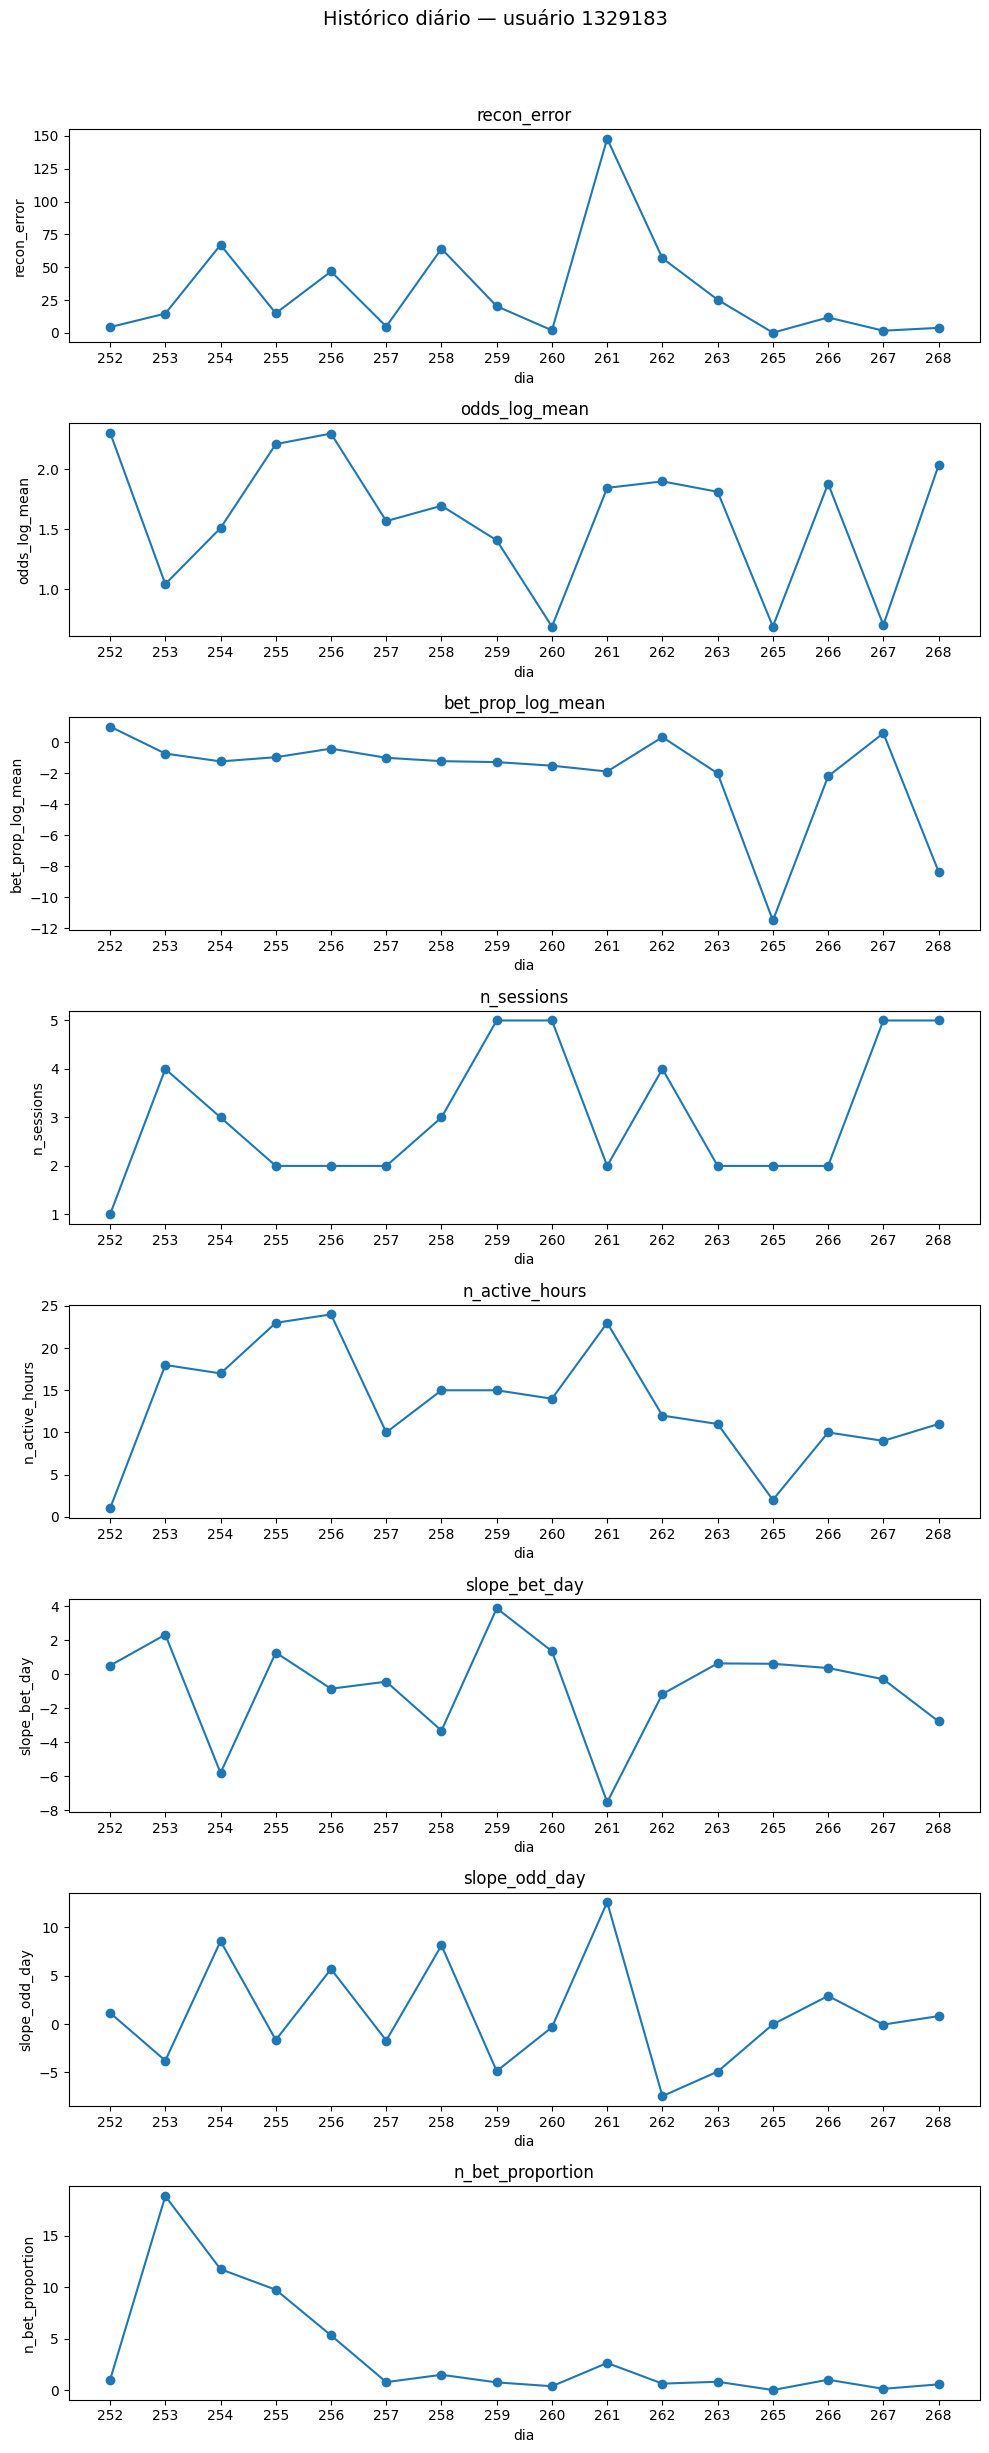

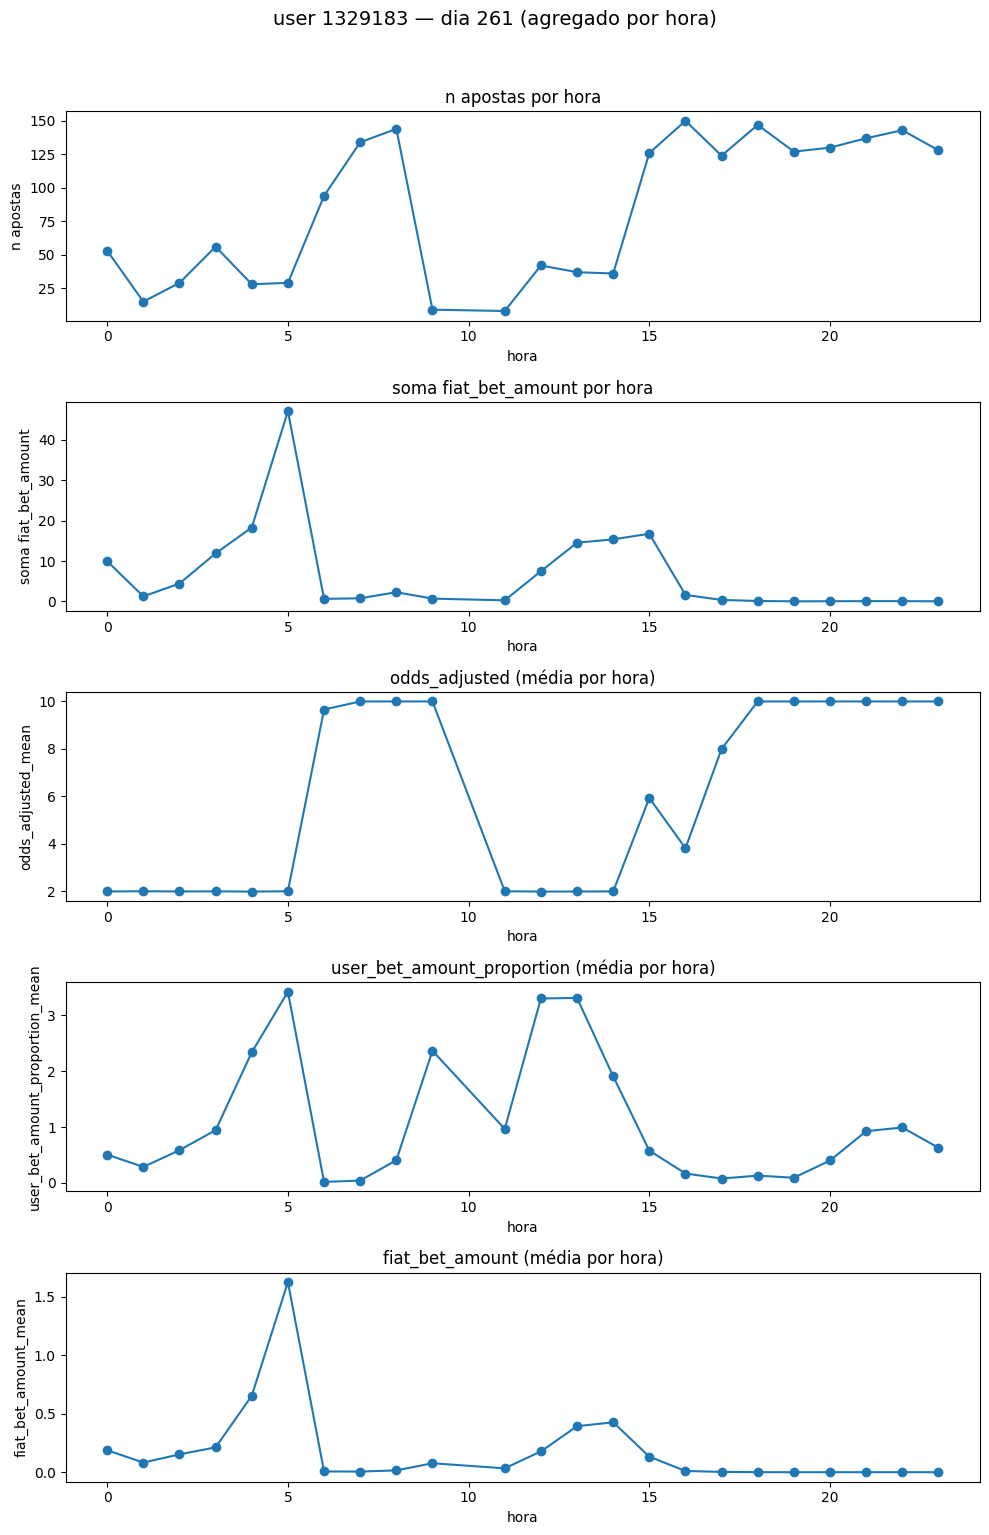

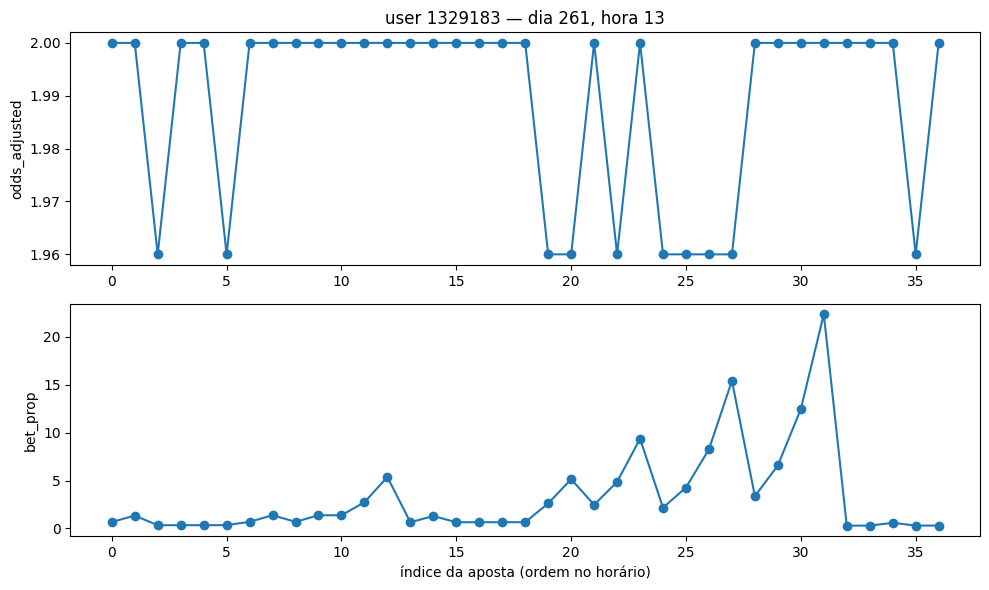

In [55]:

plot_user_daily(recon_df, user_id=user_id, features=daily_feats)
plot_user_day_hourly(
    df=bets,          
    user_id=user_id,
    day_of_year=day  
)
plot_user_hour_bets(
    df=bets,          
    user_id=user_id,
    day_of_year=day,   
    hour=hour  
)
